In [177]:
from brainrender.atlas_specific import GeneExpressionAPI
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
from tqdm import tqdm

%matplotlib widget

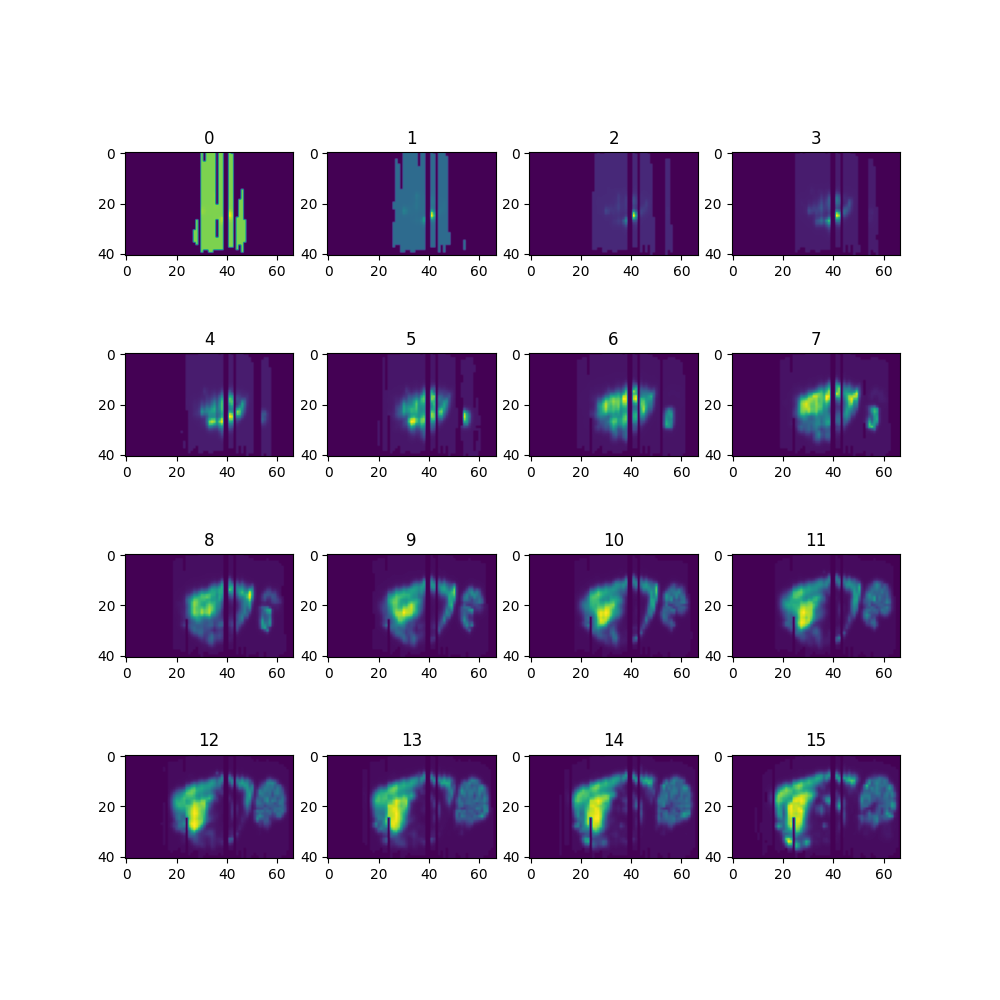

In [2]:
gene = "Pcp4"
geapi = GeneExpressionAPI()
expids = geapi.get_gene_experiments(gene)
data = geapi.get_gene_data(gene=gene,  exp_id=expids[0])

grid_size = 4
plt.figure(figsize=(10, 10))
for ii in range(grid_size**2):
    plt.subplot(grid_size, grid_size, ii + 1)
    slice_num = ii + 20
    plt.imshow(data[-ii - 1, :, :])
    plt.title(ii)
plt.show()

In [3]:
gene_info = geapi.get_all_genes()
gene_info.head()

,id,gene_symbol,gene_name,entrez_gene_id,homologene_group_id
0,158383,1700010L04Rik,RIKEN cDNA 1700010L04 gene,619808,None
1,46574,6330411E07Rik,RIKEN cDNA 6330411E07 gene,70733,None
2,106388,6330581N18Rik,RIKEN cDNA 6330581N18 gene,319453,None
3,106517,6430573F11Rik,RIKEN cDNA 6430573F11 gene,319582,35306
4,87409,A2m,alpha-2-macroglobulin,232345,37248


In [145]:
data_dims = data.shape
xs, zs, ys = [np.arange(data_dims[i]) for i in range(3)]

coords = np.array(np.meshgrid(xs, ys, zs)).T.reshape(-1, 3)
outcome = np.array([data[c[0], c[2], c[1]] for c in coords])
assert len(outcome) == len(coords)

In [146]:
observed_idx = np.where(outcome > 1)
coords = coords[observed_idx]
coords[:, 2] = np.max(coords[:, 2]) - coords[:, 2]
outcome = outcome[observed_idx]

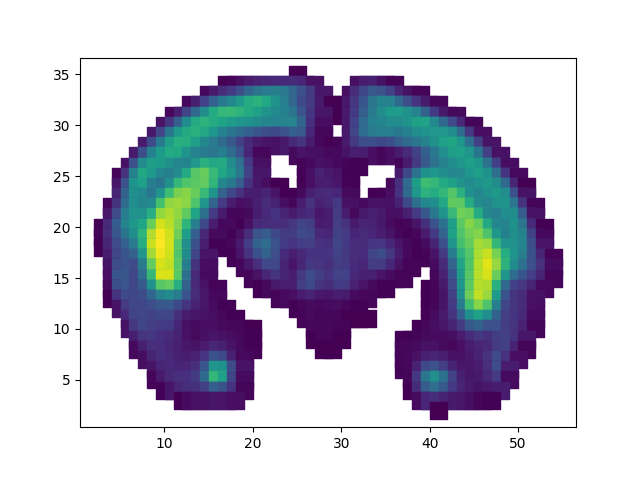

In [151]:
plt.close()
y_slice_idx = 30
coords_subset = coords[coords[:, 1] == y_slice_idx]
plt.scatter(coords_subset[:, 0], coords_subset[:, 2], c=outcome[coords[:, 1] == z_slice_idx], marker="s", s=150)
plt.show()

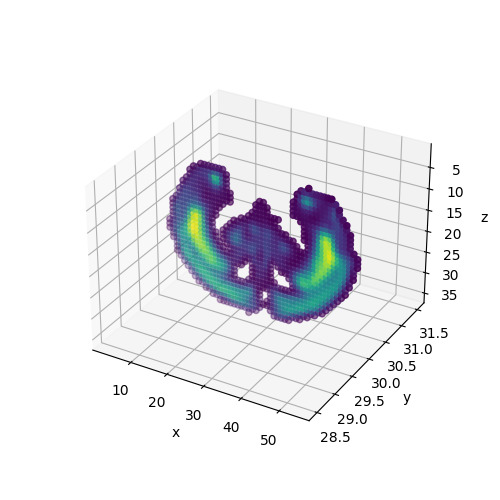

In [157]:
plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
# ax.scatter3D(coords[:, 0], coords[:, 1], coords[:, 2], c=outcome)
y_idx = 30
ax.scatter3D(coords[:, 0][coords[:, 1] == y_idx], coords[:, 1][coords[:, 1] == y_idx], coords[:, 2][coords[:, 1] == y_idx], c=outcome[coords[:, 1] == y_idx])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.invert_zaxis()
plt.show()

In [161]:
dists

array([22.04540769, 22.86190427, 21.63715939, ..., 37.55884272,
       37.96709101, 38.3753393 ])

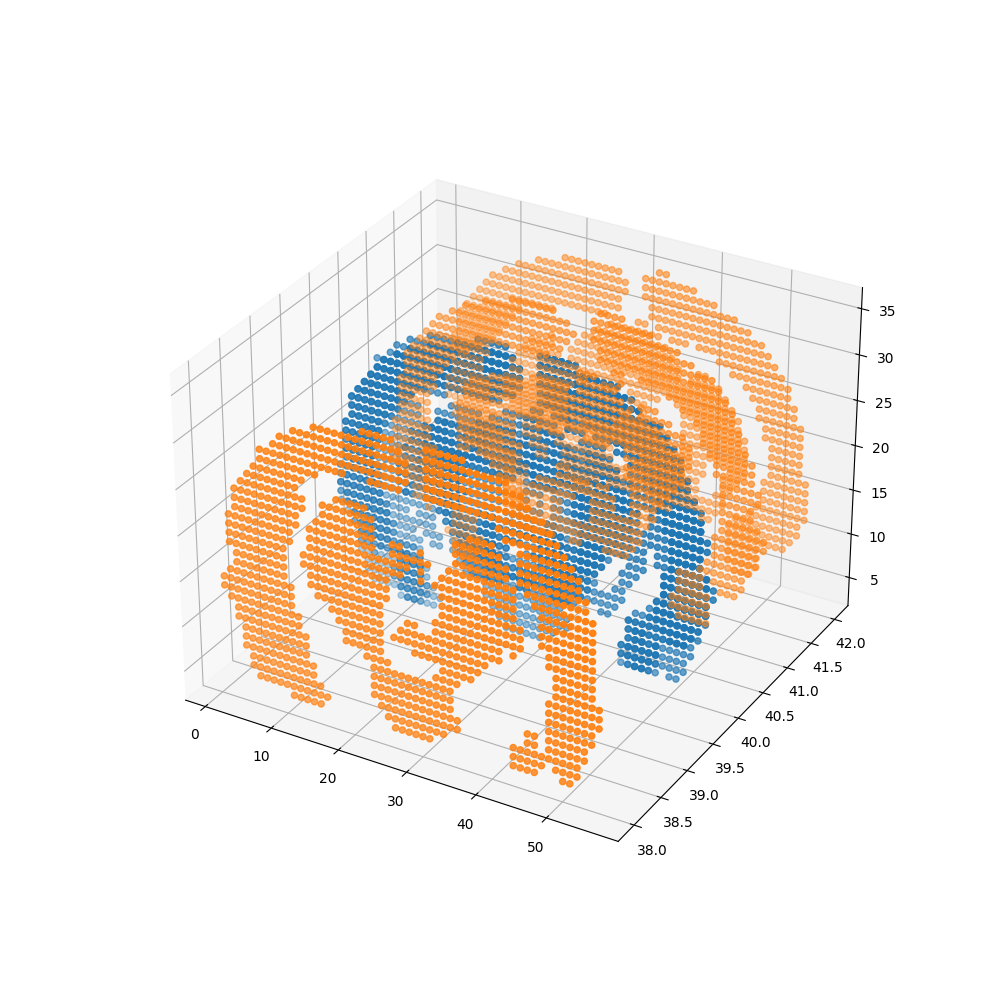

In [165]:
P = np.array([0, -1, 0, 40])
dists = np.abs(P[0] * coords[:, 0] + P[1] * coords[:, 1] + P[2] * coords[:, 2] + P[3]) / np.sqrt(np.sum(P[:3] ** 2))
close_idx = np.where(dists < 3)


normal_vector = P[:3] / np.linalg.norm(P[:3], ord=2)
dists_signed = (P[0] * coords[:, 0] + P[1] * coords[:, 1] + P[2] * coords[:, 2] + P[3]) / np.linalg.norm(P[:3], ord=2)
projected_points = coords[close_idx] - (dists_signed[close_idx] * normal_vector.reshape(-1, 1)).T

projected_point_dists = np.abs(P[0] * projected_points[:, 0] + P[1] * projected_points[:, 1] + P[2] * projected_points[:, 2] + P[3]) / np.linalg.norm(P[:3], ord=2)
assert np.allclose(projected_point_dists, 0)

plt.close()
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(projected_points[:, 0], projected_points[:, 1], projected_points[:, 2])
ax.scatter3D(coords[close_idx][:, 0], coords[close_idx][:, 1], coords[close_idx][:, 2])

plt.show()

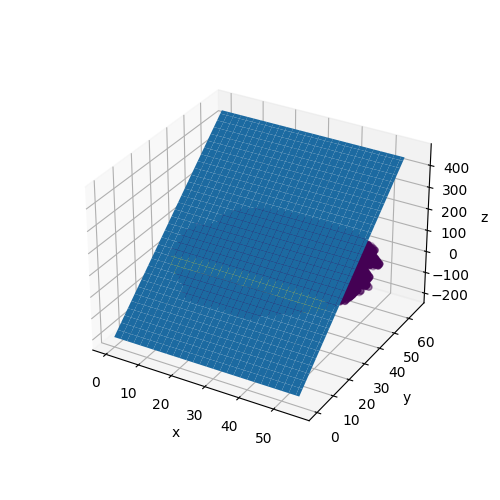

In [174]:
plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')

P = np.array([0, -1, 0.1, 20])

dists = np.abs(P[0] * coords[:, 0] + P[1] * coords[:, 1] + P[2] * coords[:, 2] + P[3]) / np.sqrt(np.sum(P[:3] ** 2))
ax.scatter3D(coords[:, 0], coords[:, 1], coords[:, 2], c=dists < 3, alpha=0.3)

xx, yy = np.meshgrid(range(np.max(coords[:, 0])), range(np.max(coords[:, 1])))
z = (P[0] * xx + P[1] * yy + P[3]) / -P[2]
ax.plot_surface(xx, yy, z)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

plt.show()

In [190]:
kernel = RBF()

y_slices = np.arange(np.min(coords[:, 1]), 40) #np.max(coords[:, 1]))
eigs = np.zeros(len(y_slices))
dist_threshold = 3

for ii, yslice in enumerate(y_slices):
    
    # Define plane
    P = np.array([0, -1, 0, yslice])
    
    # Find points observed by this slice
    dists = np.abs(P[0] * coords[:, 0] + P[1] * coords[:, 1] + P[2] * coords[:, 2] + P[3]) / np.sqrt(np.sum(P[:3] ** 2))
    close_idx = np.where(dists <= dist_threshold)

    normal_vector = P[:3] / np.linalg.norm(P[:3], ord=2)
    dists_signed = (P[0] * coords[:, 0] + P[1] * coords[:, 1] + P[2] * coords[:, 2] + P[3]) / np.linalg.norm(P[:3], ord=2)
    projected_points = coords[close_idx] - (dists_signed[close_idx] * normal_vector.reshape(-1, 1)).T
    
    # Ensure that projection worked
    projected_point_dists = np.abs(P[0] * projected_points[:, 0] + P[1] * projected_points[:, 1] + P[2] * projected_points[:, 2] + P[3]) / np.linalg.norm(P[:3], ord=2)
    assert np.allclose(projected_point_dists, 0)
    
    # Compute EIG
    cov = kernel(projected_points)
    noise_variance = 1e-2
    eig = 0.5 * np.linalg.slogdet(1 / noise_variance * cov + np.eye(len(projected_points)))[
        1
    ]
    eigs[ii] = eig

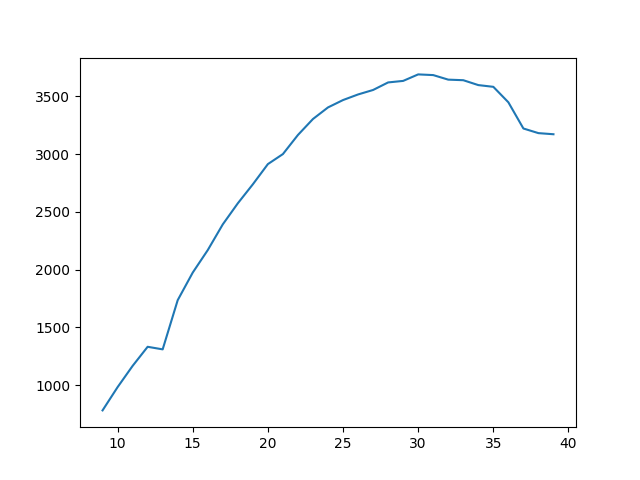

In [191]:
plt.close()
plt.plot(y_slices, eigs)
plt.show()